### Overview of GAN
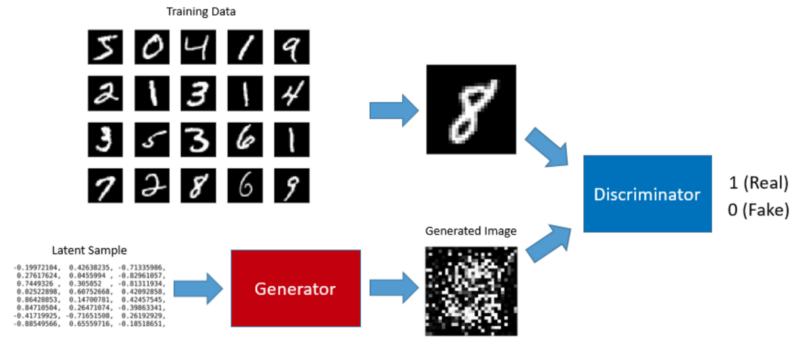

- **Generative** models can generate new data instances.
- **Discriminative** models discriminate between different kinds of data instances.

A generative model could generate new photos of animals that look like real animals, while a discriminative model could tell a dog from a cat.

The discriminator in a GAN is simply a classifier. It tries to distinguish real data from the data created by the generator.


https://developers.google.com/machine-learning/gan/gan_structure

Import libraries

In [1]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

In [3]:
os.makedirs("./images/gan",exist_ok = True)

**HyperParameters**

In [4]:
BATCH_SIZE = 64
N_EPOCHS = 100
IMAGE_SIZE = 28*28   # 784
LATENT_DIM = 100
PRINT_EVERY = 5
N_SHOW = 5

In [5]:
latent_dim = torch.rand(BATCH_SIZE, LATENT_DIM)

In [6]:
latent_dim

tensor([[0.2592, 0.7745, 0.1239,  ..., 0.3445, 0.8502, 0.7164],
        [0.3121, 0.6866, 0.2719,  ..., 0.4155, 0.5289, 0.0151],
        [0.3213, 0.3181, 0.5585,  ..., 0.1326, 0.5560, 0.5311],
        ...,
        [0.0263, 0.2727, 0.6808,  ..., 0.1229, 0.4645, 0.7951],
        [0.6379, 0.8983, 0.0820,  ..., 0.8650, 0.1535, 0.6624],
        [0.6533, 0.4505, 0.5888,  ..., 0.1303, 0.4268, 0.9990]])

In [7]:
latent_dim.shape

torch.Size([64, 100])

A "**latent dimension**" refers to a single dimension within a "latent space," which is a lower-dimensional representation of data where the essential features of the original high-dimensional data are captured, essentially representing the underlying hidden patterns or structures within the data that are not directly observable

In [8]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [9]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5))  # mean, std. deviation
])

**transforms.Compose** just clubs all the transforms provided to it. So, all the transforms in the `transforms.Compose` are applied to the input one by one.

**Normalizing pixels** is to divide each pixel value by the maximum value that a pixel can take. For example, for an 8-bit image, the maximum pixel value is 255, so to normalize the pixels, you would divide each pixel value by 255. This scales the pixel values to a range of 0 to 1.


---

Given mean: `(mean[1],...,mean[n])` and std: `(std[1],..,std[n])` for `n` channels, this transform will normalize each channel of the input `torch.*Tensor` i.e., `output[channel] = (input[channel] - mean[channel]) / std[channel]`

In [10]:
data = datasets.MNIST('.data',train = True, download = True, transform = transforms,)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.19MB/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



In [11]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: .data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=0.5)
           )

In [12]:
iterator = DataLoader(data, batch_size = BATCH_SIZE, drop_last = True, shuffle = True) #60,000 ko batches mein convert karega

In [13]:
len(iterator)

937

In [14]:
60000/BATCH_SIZE # drop_last is dropping the last image

937.5

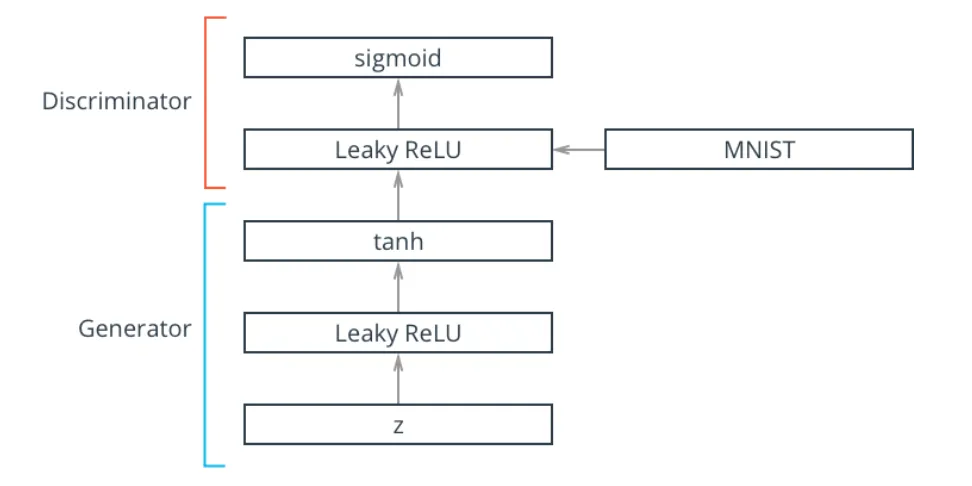

**Generative Model**

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

**ReLU** stands for Rectified Linear Unit. The function is defined as f(x) = max(0, x), which returns the input value if it is positive and zero if it is negative.


---
Relu `does not suffer` from the `vanishing gradient problem`.

However, ReLU can suffer from the `dying ReLU` problem, where a neuron with a negative bias may never activate, resulting in a “dead” neuron. To avoid this, variants of ReLU have been proposed, such as leaky ReLU, exponential ReLU, and others.

---
The Dying ReLU problem can occur (while using ReLU activation function) when the weights of a neuron are adjusted so that the bias term becomes very negative. When this happens, the neuron will always receive negative inputs, and its output will always be zero, which means it will not contribute to the network's output.

---
The **Leaky ReLU function** is f(x) = max(ax, x), where x is the input to the neuron, and a is a small constant, typically set to a value like 0.01. When x is positive, the Leaky ReLU function behaves like the ReLU function, returning x. However, when x is negative, the Leaky ReLU function returns a small negative value proportional to the input x.

---

Leaky ReLU ensures that all neurons in the network can contribute to the output, even if their inputs are negative.



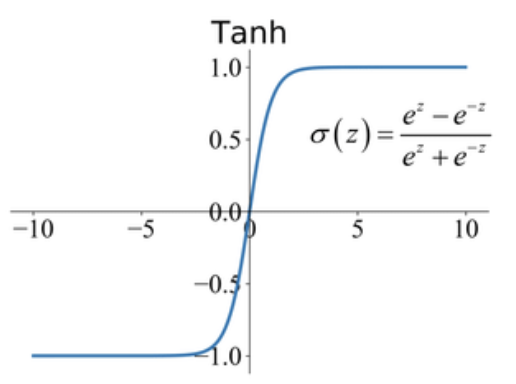

**DISCRIMINATOR**

In [16]:
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # During training, randomly zeroes some of the elements of the input tensor with probability 0.3 here in this case.

            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256,1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x).squeeze(1)

In [17]:
G = Generator(LATENT_DIM, IMAGE_SIZE).to(device)

In [18]:
D = Discriminator(IMAGE_SIZE).to(device)

### Loss Function

In [19]:
criterion = nn.BCELoss()

### Optimizer

In [20]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))

**LABELS**

In [24]:
real_labels = torch.ones(BATCH_SIZE).to(device)

In [25]:
real_labels

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [26]:
fake_labels = torch.zeros(BATCH_SIZE).to(device)

**Function Time**

In [27]:
def epoch_time(start_time,end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time-(elapsed_mins*60))
    return elapsed_mins, elapsed_secs

### TRAINING LOOP

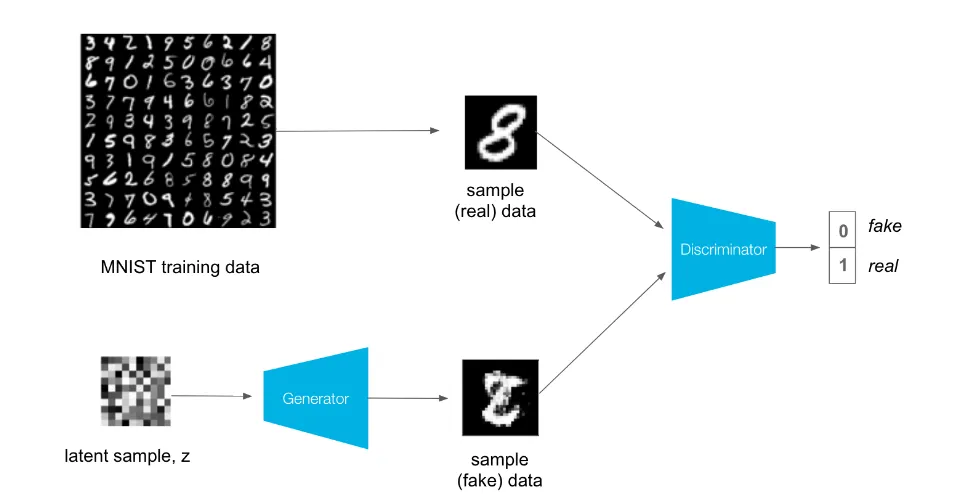

In [30]:
# for epoch in range(1, N_EPOCHS+1): #100 times in our case
#     start_time = time.time()
#     for _ in range(len(iterator)): #937 times in our case each having 64 images
#         # train discriminator : Based on real images of the world
#         x,_ = next(iter(iterator)) # x has images (batch_size, channels, height, width = 64, 1, 28, 28), _ has labels
#         x = x.to(device)
#         x = x.view(-1,IMAGE_SIZE) # -1 is used when you don't know batch size no.

#         z = torch.randn(x.shape[0], LATENT_DIM)

#         with torch.no_grad():
#             generated_images = G(z) # Generates 64 images
#         pred_real = D(x) # x -> Real images => 64 predictions : 0/1

#         D_error_real = criterion(pred_real, real_labels)

#         pred_fake = D(generated_images)
#         D_error_fake = criterion(pred_fake, fake_labels)

#         D_error = D_error_real + D_error_fake
#         D_error.backward()
#         D.optimizer.step()

#         # Generator training
#         G.zero_grad()
#         x,_ = next(iter(iterator))
#         x = x.to(device)
#         x = x.view(-1, IMAGE_SIZE)
#         z = torch.randn(x.shape[0],LATENT_DIM).to(device)
#         generated_images = G(z)
#         pred_fake = D(generated_images)
#         G_error = criterion(pred_fake, real_labels)
#         G_error.backward()
#         G.optimizer.step()

In [31]:
28*28

784

| Epoch: 005 | D_error: 1.080 | G_error: 3.364 | Time: 0m 43s


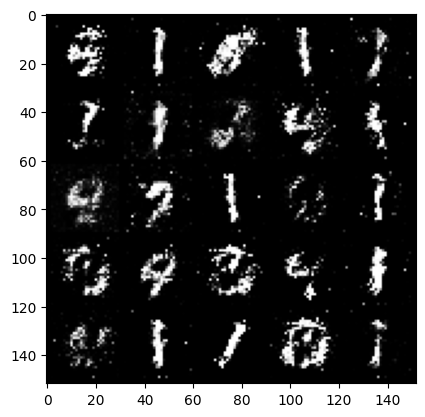

| Epoch: 010 | D_error: 1.215 | G_error: 0.958 | Time: 0m 46s


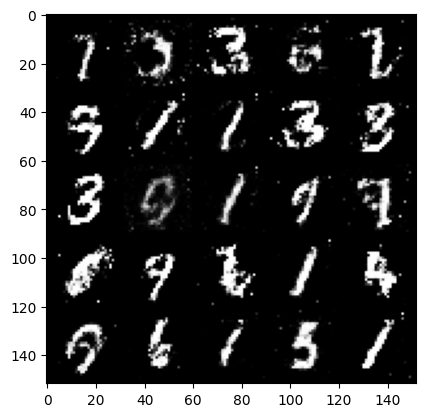

| Epoch: 015 | D_error: 1.334 | G_error: 1.060 | Time: 0m 43s


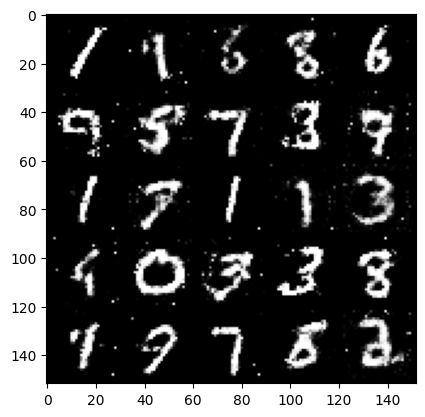

| Epoch: 020 | D_error: 1.250 | G_error: 1.222 | Time: 0m 45s


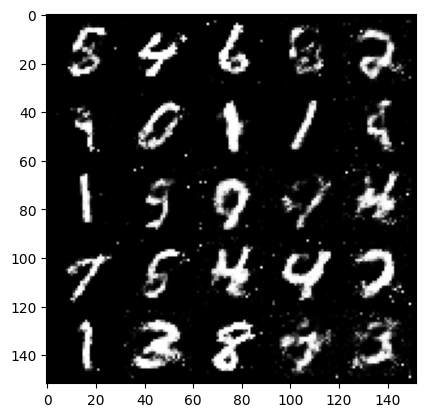

| Epoch: 025 | D_error: 1.078 | G_error: 0.992 | Time: 0m 44s


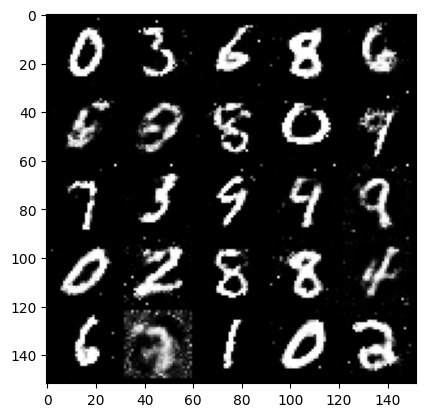

| Epoch: 030 | D_error: 1.119 | G_error: 0.865 | Time: 0m 43s


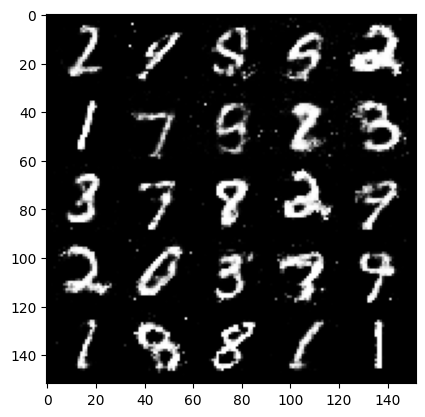

| Epoch: 035 | D_error: 1.116 | G_error: 1.101 | Time: 0m 43s


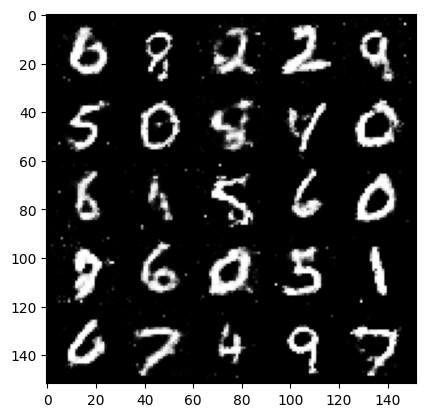

| Epoch: 040 | D_error: 1.261 | G_error: 1.080 | Time: 0m 42s


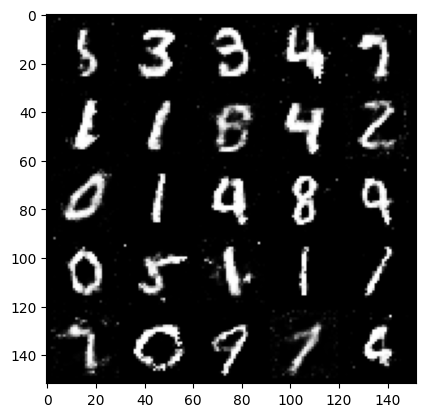

| Epoch: 045 | D_error: 1.206 | G_error: 0.913 | Time: 0m 42s


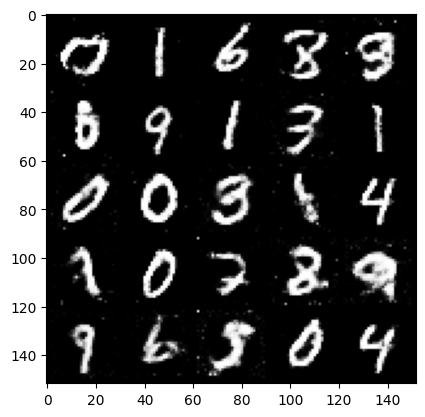

| Epoch: 050 | D_error: 1.100 | G_error: 1.095 | Time: 0m 45s


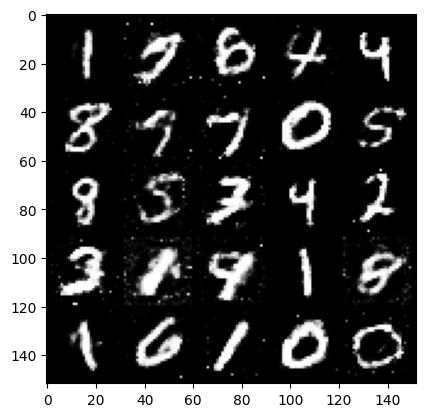

| Epoch: 055 | D_error: 1.159 | G_error: 1.065 | Time: 0m 43s


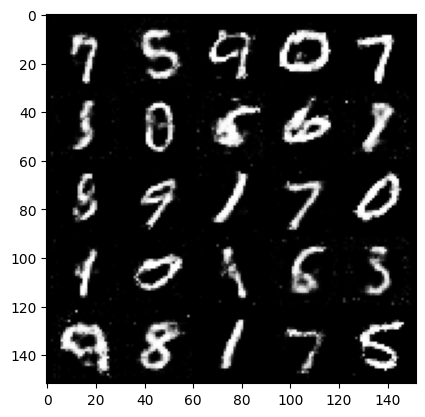

| Epoch: 060 | D_error: 1.193 | G_error: 0.922 | Time: 0m 43s


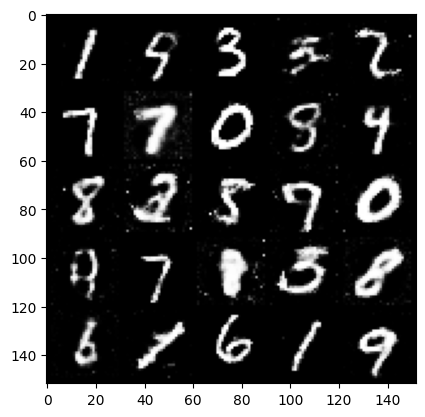

| Epoch: 065 | D_error: 1.241 | G_error: 1.001 | Time: 0m 42s


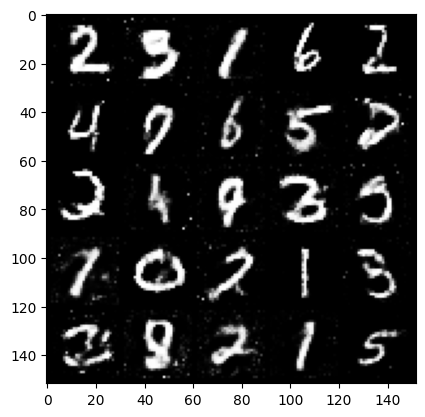

| Epoch: 070 | D_error: 1.274 | G_error: 0.957 | Time: 0m 43s


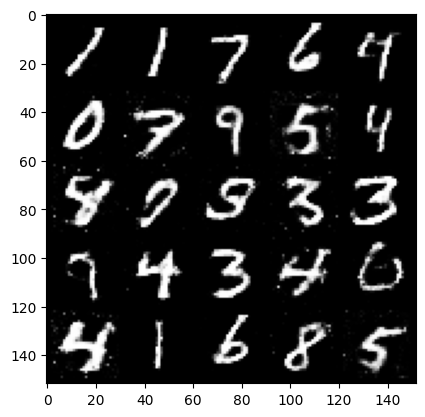

KeyboardInterrupt: 

In [32]:
for epoch in range(1, N_EPOCHS+1):

    start_time = time.time()

    for _ in range(len(iterator)):

        #=====================#
        # TRAIN DISCRIMINATOR #
        #=====================#

        #zero discriminator gradients
        D.zero_grad()

        #get batch of real images
        x, _ = next(iter(iterator))

        #place images on GPU
        x = x.to(device)

        #flatten images
        x = x.view(-1, IMAGE_SIZE)

        #sample noise
        z = torch.randn(x.shape[0], LATENT_DIM).to(device)

        #generate images
        with torch.no_grad():
            generated_images = G(z)

        #put real images through discriminator
        pred_real = D(x)

        #how well does the discriminator detect real images?
        D_error_real = criterion(pred_real, real_labels)

        #put fake images through the discriminator
        #need to detach so don't backpropagate through generator
        pred_fake = D(generated_images.detach())

        #how well does the discriminator detect fake images?
        D_error_fake = criterion(pred_fake, fake_labels)

        #get discriminator error
        D_error = D_error_real + D_error_fake

        #backpropagate errors to get gradients
        D_error.backward()

        #use gradient to update discriminator parameters
        D_optimizer.step()

        #=================#
        # TRAIN GENERATOR #
        #=================#

        #zero generator gradients
        G.zero_grad()

        #get batch of real images
        x, _ = next(iter(iterator))

        #place images on GPU
        x = x.to(device)

        #flatten images
        x = x.view(-1, IMAGE_SIZE)

        #sample noise
        z = torch.randn(x.shape[0], LATENT_DIM).to(device)

        #generate images
        generated_images = G(z)

        #put fake images through the discriminator
        pred_fake = D(generated_images)

        #how well does the generator fool the discriminator?
        G_error = criterion(pred_fake, real_labels)

        #backpropagate errors to get gradients
        G_error.backward()

        #use gradient to update generator parameters
        G_optimizer.step()

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch % PRINT_EVERY) == 0:

        #sample noise
        z = torch.randn(N_SHOW*N_SHOW, LATENT_DIM).to(device)

        #generate images
        with torch.no_grad():
            generated_images = G(z)

        #reshape to (batch, channel, height, width)
        generated_images = generated_images.view(-1, 1, 28, 28)

        print(f'| Epoch: {epoch:03} | D_error: {D_error.item():.03f} | G_error: {G_error.item():.03f} | Time: {epoch_mins}m {epoch_secs}s')

        #save N_SHOW*N_SHOW images
        torchvision.utils.save_image(generated_images,
                                     f'images/gan/epoch{epoch:03}.png',
                                     nrow=N_SHOW,
                                     normalize=True)

        #display images
        img = plt.imread(f'images/gan/epoch{epoch:03}.png')
        plt.imshow(img)
        plt.show()